# Interpreting BERT Models using XAI

In this notebook we demonstrate use the `Captum` library to interpret some results of our BERT models. 

This notebook was mainly inspired by this [Captum Tutorial](https://captum.ai/tutorials/Bert_SQUAD_Interpret) and a [GitHub discussion](https://github.com/pytorch/captum/issues/150#issuecomment-549022512).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.dirname(os.path.dirname(os.path.abspath(os.path.join('.'))))
if module_path not in sys.path:
    print('Add root path to system path: ', module_path)
    sys.path.append(module_path)
module_path += '/'

Add root path to system path:  D:\Projets\Georgia Tech\Comp Social Science\cs6471-project


In [3]:
import gc
import tqdm
import argparse
import numpy as np
import datetime
import time

import spacy
import pandas as pd
from sklearn.metrics import f1_score

from torch import optim
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from src.utils.preprocess_utils import *
from src.training.train_utils import train_model, test_model
from src.evaluation.test_save_stats import *

from src.utils.utils import *
from src.evaluation.xai_utils import *

import captum
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients

from typing import Any, Iterable, List, Tuple, Union
from IPython.core.display import HTML, display

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Richard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## ⚠️ Before running the cells below, make sure to run :

- test_save_stats.py --model=MODEL_NAME--saved_model_path=PATH_TO_MODEL (see source code for more details) + any model parameters needed

The code saves the samples for which the model is sure of its prediction (ie. when it the probability is either really close to 1 (Hate) or close to 0 (Neutral)). <br>
We are now going to visualize the explainability of the model (ie. the importance of words in the model's decision) respectively for True Positives (TP), False Positives (FP), True Negatives (TN) and False Negatives(FN).

In [4]:
## Put your model hyperparameters here
model_type = 'DistillBert'
saved_model_path = module_path + SAVED_MODELS_PATH + 'DistillBert_2022-04-15_02-48-34_trained_testAcc=0.8026.pth'
stats_path = module_path + STATS_CSV + "stats_DistillBert_2022-04-15_02-48-34_test_crossentropy.csv"

In [5]:
# Specific other parameters
fix_length = None

In [6]:
train_dataset_name = 'offenseval'
test_dataset_name = 'offenseval'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)

field, tokenizer, _, _, _ = get_datasets(train_dataset_name, test_dataset_name, model_type, fix_length, 
                                         module_path=module_path)

print("Loading vocabulary...")
vocab_stoi, vocab_itos = get_vocab_stoi_itos(field)
print("Vocabulary Loaded")

Device: cuda
pad_index 0
field objects created
fields and dataset object created
vocabulary built..
Loading vocabulary...
Vocabulary Loaded


In [7]:
print("Loading Model...")
model = load_model(model_type, field, device)
model = load_trained_model(model, saved_model_path, device)
print("Model Loaded.")

Loading Model...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


D:\Projets\Georgia Tech\Comp Social Science\cs6471-project/saved-models/DistillBert_2022-04-15_02-48-34_trained_testAcc=0.8026.pth loaded.
Model Loaded.


In [8]:
print("Loading Stats Data..")
df = pd.read_csv(stats_path)
df = df.drop(columns=["Unnamed: 0"])
print(df.shape)
df.head()

Loading Stats Data..
(860, 6)


,original_index,text,true_label,pred_label,prob,loss
0,0,[CLS] whoisq wherestheserver dumpnike declasfi...,1,1,0.548699,0.600205
1,1,[CLS] constitutionday is revered by conservati...,0,0,0.432062,0.565743
2,2,[CLS] foxnews nra maga potus trump 2ndamendmen...,0,0,0.091411,0.095862
3,3,[CLS] watching boomer getting the news that sh...,0,0,0.128311,0.137322
4,4,[CLS] nopasaran : unity demo to oppose the far...,1,0,0.123655,2.090264


In [9]:
## Selecting TP, FP, TN, FN

df_tp =   df[(df['true_label']==1) & (df['pred_label']==1) ]
df_fp =   df[(df['true_label']==0) & (df['pred_label']==1) ]
df_tn =   df[(df['true_label']==0) & (df['pred_label']==0) ]
df_fn =   df[(df['true_label']==1) & (df['pred_label']==0) ]

print("TP, FP, TN, FN selected from loaded data.")

TP, FP, TN, FN selected from loaded data.


## Preprocessing and gradient methods

In [10]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used for the end of a sentence
cls_token_id = tokenizer.cls_token_id # A token used for the start of a sentence

print('ref_token_id', ref_token_id)
print('sep_token_id', sep_token_id)
print('cls_token_id', cls_token_id)

def construct_input_ref_pair_from_raw(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]
    ref_input_ids = torch.tensor(ref_input_ids, device=device).unsqueeze(0)

    return input_ids, ref_input_ids


def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = text_ids
    input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * (len(text_ids) - 2) + [sep_token_id]
    ref_input_ids = torch.tensor(ref_input_ids, device=device).unsqueeze(0)

    return input_ids, ref_input_ids

ref_token_id 0
sep_token_id 102
cls_token_id 101


In [11]:
%%time
# https://github.com/pytorch/captum/issues/150#issuecomment-549022512
def compute_bert_outputs(model_bert, embedding_output, attention_mask=None, head_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_output.shape[0], embedding_output.shape[1]).to(embedding_output)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(dtype=next(model_bert.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(dtype=next(model_bert.parameters()).dtype) # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.transformer(embedding_output, attention_mask, head_mask=head_mask)
    sequence_output = encoder_outputs[0]
    pooled_output = sequence_output.mean(axis=1)
    outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
    return outputs  # sequence_output, pooled_output, (hidden_states), (attentions) 


class BertModelWrapper(nn.Module):
    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model
        
    def forward(self, embeddings):        
        outputs = compute_bert_outputs(self.model.bert, embeddings)
        pooled_output = outputs[1]
        pooled_output = self.model.dropout(pooled_output)
        out = self.model.relu(self.model.linear1(pooled_output))
        logits = self.model.linear2(out)
        return torch.softmax(logits, dim=1)[:, 1].unsqueeze(1)


def interpret_sentence(model_wrapper, sentence, label, original_idx, vis_data_records_ig, device, raw_text=False):
    torch.cuda.empty_cache()
    gc.collect()
    model_wrapper.eval()
    model_wrapper.zero_grad()

    # print('sentence: ', sentence)

    if raw_text:
        input_ids, ref_input_ids = construct_input_ref_pair_from_raw(sentence, ref_token_id, 
                                                                     sep_token_id, cls_token_id)
    else:
        input_ids, ref_input_ids = construct_input_ref_pair(sentence, ref_token_id, 
                                                            sep_token_id, cls_token_id)
    input_embedding = model_wrapper.model.bert.embeddings(input_ids).to(device)
    

    # predict
    pred = model_wrapper(input_embedding).item()
    pred_ind = round(pred)

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = ig.attribute(input_embedding, return_convergence_delta=True)

    # print('pred: ', pred_ind, '(', '%.2f' % pred, ')', ', delta: ', abs(delta))
    

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().numpy().tolist()) 
    # print('tokens:', tokens)
    add_attributions_to_visualizer(attributions_ig, tokens, pred, pred_ind, label, delta, original_idx, vis_data_records_ig)
    
    torch.cuda.empty_cache()
    del attributions_ig, tokens, input_ids, input_embedding, pred, pred_ind
    gc.collect()

def add_attributions_to_visualizer(attributions, tokens, pred, pred_ind, label, delta, original_idx, 
                                   vis_data_records, class_names=["Neutral","Hate"]):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.detach().cpu().numpy()
    
    # storing couple samples in an array for visualization purposes visualization.VisualizationDataRecord
    datarecord = VisualizationDataRecordCustom(attributions,
                                                pred,
                                                class_names[pred_ind],
                                                class_names[label],
                                                class_names[1],
                                                attributions.sum(),       
                                                tokens[:len(attributions)],
                                                delta, 
                                                original_idx,)
    vis_data_records.append(datarecord)


bert_model_wrapper = BertModelWrapper(model).to(device)
ig = IntegratedGradients(bert_model_wrapper)

# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

sentence, label = "you little chicken", 1

interpret_sentence(bert_model_wrapper, sentence=sentence, label=label, original_idx=0, 
                   vis_data_records_ig=vis_data_records_ig, device=device, raw_text=True)
visualize_text(vis_data_records_ig)

Original Index,True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,Hate,Hate (0.87),Hate,1.37,[CLS] you little chicken [SEP]


Wall time: 857 ms


Original Index,True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,Hate,Hate (0.87),Hate,1.37,[CLS] you little chicken [SEP]


# Data Visualization

We are now going to visualize words' importances in the decision process. <br>
For each category (TP, FP, TN, FN), we visualize importances for both the highest scores and lowest scores.

## True Positives

In [12]:
lowest_stats_df_tp, highest_stats_df_tp = get_highest_lowest_metric_indexes(df_tp, stats_metric='prob', stats_topk=10)

#### Highest Scores 

In [13]:
%%time
dataset_visualization_bert(interpret_sentence, ig, visualize_text, bert_model_wrapper, highest_stats_df_tp,\
                           device, max_samples=10, partial_vis=True)



**MODEL EXPLAINABILITY**

Computing words importance for each sample... 
Computations completed.


**LOADING VISUALIZATION**



Wall time: 3.75 s


## False Positives

In [14]:
lowest_stats_df_fp, highest_stats_df_fp = get_highest_lowest_metric_indexes(df_fp, stats_metric='prob', stats_topk=10)

#### Lowest Scores 

In [15]:
%%time
dataset_visualization_bert(interpret_sentence, ig, visualize_text, bert_model_wrapper, highest_stats_df_fp,\
                           device, max_samples=10,partial_vis=True)



**MODEL EXPLAINABILITY**

Computing words importance for each sample... 
Computations completed.


**LOADING VISUALIZATION**



Wall time: 4.69 s


## True Negatives

In [16]:
lowest_stats_df_tn, highest_stats_df_tn = get_highest_lowest_metric_indexes(df_tn, stats_metric='prob', stats_topk=10)

#### Highest Scores 

In [17]:
%%time
dataset_visualization_bert(interpret_sentence, ig, visualize_text, bert_model_wrapper, lowest_stats_df_tn,\
                           device, max_samples=10,partial_vis=True)



**MODEL EXPLAINABILITY**

Computing words importance for each sample... 
Computations completed.


**LOADING VISUALIZATION**



Wall time: 4.92 s


## False Negatives

In [18]:
lowest_stats_df_fn, highest_stats_df_fn = get_highest_lowest_metric_indexes(df_fn, stats_metric='prob', stats_topk=10)

#### Lowest Scores 

In [19]:
%%time
dataset_visualization_bert(interpret_sentence, ig, visualize_text, bert_model_wrapper, lowest_stats_df_fn,\
                           device, max_samples=10,partial_vis=True)



**MODEL EXPLAINABILITY**

Computing words importance for each sample... 
Computations completed.


**LOADING VISUALIZATION**



Wall time: 4.6 s


# Visualize a sentence by its index

### True Positive

In [20]:
list_indexes = [433, 730, 259, 406]
df_by_indexes = df.iloc[list_indexes]

In [21]:
%%time
dataset_visualization_bert(interpret_sentence, ig, visualize_text, bert_model_wrapper, df_by_indexes,\
                           device, max_samples=10,partial_vis=True)



**MODEL EXPLAINABILITY**

Computing words importance for each sample... 
Computations completed.


**LOADING VISUALIZATION**



Original Index,True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
433,Hate,Hate (0.94),Hate,1.60,[CLS] @ user damn i felt this shit . why you so loud lo ##l [SEP]
730,Hate,Hate (0.94),Hate,1.52,[CLS] and she has a pet ? ? ? fucking disgusting ur ##l [SEP]
259,Hate,Hate (0.95),Hate,1.50,[CLS] ! ! ! ! bitch i ’ m fucking coming back ur ##l [SEP]
406,Hate,Hate (0.94),Hate,1.59,[CLS] alright let me get right with god bc mother nature is like fuck humans ur ##l [SEP]


Wall time: 1.41 s


### False Positive

In [22]:
list_indexes = [674, 599, 278, 700]
df_by_indexes = df.iloc[list_indexes]

In [23]:
%%time
dataset_visualization_bert(interpret_sentence, ig, visualize_text, bert_model_wrapper, df_by_indexes,\
                           device, max_samples=10,partial_vis=True)



**MODEL EXPLAINABILITY**

Computing words importance for each sample... 
Computations completed.


**LOADING VISUALIZATION**



Wall time: 1.96 s


## Statistics on Attribution scores

⚠️ The pkl file is quite big (~300 Mo for offenseval), please use `in_place = True` to not save the pkl file and do all the operations in-place ⚠️

In [24]:
import pickle

from scipy import stats as scipy_stats

from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

import seaborn as sns

In [25]:
def interpret_sentence_with_stats(model_wrapper, sentence, label, original_idx, device, raw_text=False):
    torch.cuda.empty_cache()
    gc.collect()
    model_wrapper.eval()
    model_wrapper.zero_grad()

    # print('sentence: ', sentence)

    if raw_text:
        input_ids, ref_input_ids = construct_input_ref_pair_from_raw(sentence, ref_token_id, 
                                                                     sep_token_id, cls_token_id)
    else:
        input_ids, ref_input_ids = construct_input_ref_pair(sentence, ref_token_id, 
                                                            sep_token_id, cls_token_id)
    input_embedding = model_wrapper.model.bert.embeddings(input_ids).to(device)

    # predict
    pred = model_wrapper(input_embedding).item()
    pred_ind = round(pred)

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = ig.attribute(input_embedding, return_convergence_delta=True)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().numpy().tolist()) 

    torch.cuda.empty_cache()
    return (attributions_ig, delta, tokens, input_ids, input_embedding, pred, pred_ind, label, original_idx)

def model_explainability_bert_with_stats(interpret_sentence, lig, model, df, max_samples, device):
    """
    Computing words importance for each sample in df and save stats
    """
    print("\n\n**MODEL EXPLAINABILITY**\n")
    print("Computing words importance for each sample... ")

    # accumalate couple samples in this array for visualization purposes
    stats = []

    for idx in range(max_samples):
        sentence = df.iloc[idx].text
        label = df.iloc[idx].true_label
        original_idx = df.iloc[idx].original_index
        with torch.set_grad_enabled(False):
            local_stats = interpret_sentence(model, sentence, label, original_idx, device)
            
            stats.append(local_stats)

    print("Computations completed.")
    return stats

def process_attributions_stats(attributions):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.detach().cpu().numpy()
    return attributions

In [26]:
in_place = False # Does not save pkl file
ig_stats_pkl_path = stats_path[:-3] + 'pkl'
print(ig_stats_pkl_path)

D:\Projets\Georgia Tech\Comp Social Science\cs6471-project/stats-results/stats_DistillBert_2022-04-15_02-48-34_test_crossentropy.pkl


In [27]:
%%time

if not os.path.exists(ig_stats_pkl_path) or in_place:
    max_samples = len(df)
    stats = model_explainability_bert_with_stats(interpret_sentence_with_stats, ig, bert_model_wrapper, df,\
                                                 max_samples, device)

    if not in_place:
        with open(ig_stats_pkl_path, 'wb') as f:
            pickle.dump(stats, f)
else:
    with open(ig_stats_pkl_path, 'rb') as f:
        stats = pickle.load(f)

print('length stats', len(stats))

length stats 860
Wall time: 1.25 s


In [28]:
%%time
dict_word_attributions = {}
dict_attrib_stats = {'original_idx': [], 
                     'label': [],
                     'pred': [], 
                     'pred_ind': [],
                     'attributions': [],}

for stat in stats:
    attributions_ig, delta, tokens, input_ids, input_embedding, pred, pred_ind, label, original_idx = stat
    attributions = process_attributions_stats(attributions_ig)

    for idx in range(len(tokens)):
        word = tokens[idx]
        attribution = attributions[idx]
        if word not in dict_word_attributions:
            dict_word_attributions[word] = [attribution]
        else:
            dict_word_attributions[word] += [attribution]

    dict_attrib_stats['original_idx'].append(original_idx)
    dict_attrib_stats['label'].append(label)
    dict_attrib_stats['pred'].append(pred)
    dict_attrib_stats['pred_ind'].append(pred_ind)
    dict_attrib_stats['attributions'].append(np.mean(attributions))

Wall time: 309 ms


In [29]:
dict_word_attributions_mean = {}
for word in dict_word_attributions:
    dict_word_attributions_mean[word] = np.mean(dict_word_attributions[word])

In [30]:
sorted(dict_word_attributions_mean.items(), reverse=True, key=lambda x: x[1])[:10]

[('sucks', 0.977171971971555),
 ('clown', 0.9760743453830114),
 ('pussy', 0.9515849507524688),
 ('foul', 0.9474746123499301),
 ('incapable', 0.9316079813852732),
 ('thugs', 0.9309138095619595),
 ('##ilia', 0.9285438605629031),
 ('bribery', 0.9220613257890592),
 ('pathetic', 0.9166492116445859),
 ('bully', 0.9152973113416989)]

In [31]:
sorted(dict_word_attributions_mean.items(), reverse=False, key=lambda x: x[1])[:10]

[('abused', -0.7673237527779075),
 ('##berg', -0.7235676375373028),
 ('blessed', -0.6269968411920225),
 ('##walk', -0.6109661422840769),
 ('participation', -0.6035640241457687),
 ('coalition', -0.5984756903089669),
 ('eliminated', -0.5753281830942947),
 ('compassionate', -0.5619681594681114),
 ('##ert', -0.5517383872904638),
 ('nintendo', -0.5401535439431)]

In [32]:
df_attrib_stats = pd.DataFrame.from_dict(dict_attrib_stats)
df_attrib_stats

,original_idx,label,pred,pred_ind,attributions
0,0,1,0.548699,1,0.028983
1,1,0,0.432062,0,0.039630
2,2,0,0.091411,0,0.011909
3,3,0,0.128311,0,0.021412
4,4,1,0.123655,0,0.037753
...,...,...,...,...,...
855,855,1,0.364840,0,0.030870
856,856,0,0.038002,0,-0.019501
857,857,1,0.835456,1,0.049020
858,858,0,0.483703,0,0.027341


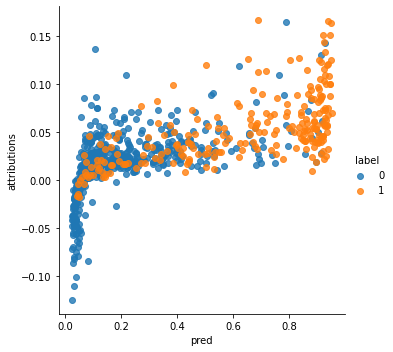

r, pvalue between pred and attributions 0.8144 5.18654888376824e-205


In [33]:
sns.lmplot(x='pred', y='attributions', data=df_attrib_stats, hue='label', fit_reg=False)
plt.show()

r, pvalue = scipy_stats.spearmanr(df_attrib_stats['pred'], df_attrib_stats['attributions'])
print('r, pvalue between pred and attributions', round(r, 4), pvalue)

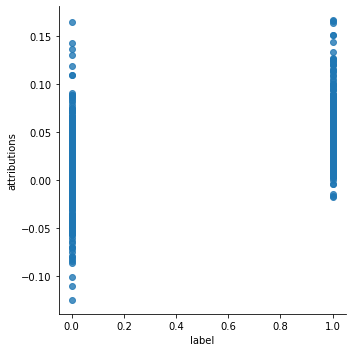

r, pvalue between label and attributions 0.4674 6.729459193600512e-48


In [34]:
sns.lmplot(x='label', y='attributions', data=df_attrib_stats, fit_reg=False)
plt.show()

r, pvalue = scipy_stats.spearmanr(df_attrib_stats['label'], df_attrib_stats['attributions'])
print('r, pvalue between label and attributions', round(r, 4), pvalue)

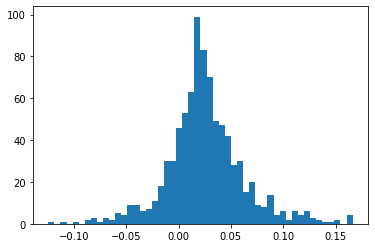

In [35]:
plt.hist(df_attrib_stats['attributions'], bins=50)
plt.show()